In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import numpy as np
import cv2
import os
from tensorflow.keras import Input
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image


In [3]:
sharpening_kernel = np.array([[0, -1, 0], 
                              [-1, 5, -1], 
                              [0, -1, 0]])

edge_detection_kernel = np.array([[-1, -1, -1], 
                                  [-1, 8, -1], 
                                  [-1, -1, -1]])

In [4]:
def preprocess_image(img):
    img_sharpened = cv2.filter2D(img, -1, sharpening_kernel)
    img_edge = cv2.filter2D(img, -1, edge_detection_kernel)
    return img_sharpened, img_edge

In [5]:
def load_and_preprocess_images(data_dir):
    images = []
    labels = []
    class_names = sorted(os.listdir(data_dir))
    
    for label in class_names:
        label_dir = os.path.join(data_dir, label)
        if not os.path.isdir(label_dir):
            continue
            
        for file in os.listdir(label_dir):
            if file.endswith('.PNG'):  # Ensure case sensitivity matches the file extensions
                img_path = os.path.join(label_dir, file)
                img = cv2.imread(img_path)
                
                if img is None:
                    print(f"Warning: Unable to load image {img_path}")
                    continue
                
                img = cv2.resize(img, (64, 64))  # Resize to a uniform size
                img_sharpened, img_edge = preprocess_image(img)
                combined_img = np.concatenate((img_sharpened, img_edge), axis=-1)
                images.append(combined_img)
                labels.append(class_names.index(label))
    
    print(f"Total images loaded: {len(images)}")
    return np.array(images), np.array(labels), class_names

In [6]:
data_dir = 'Nail/Nail_Images/train'
X, y, class_names = load_and_preprocess_images(data_dir)


Total images loaded: 647


In [7]:
if len(X) == 0:
    raise ValueError("No images were loaded. Please check the directory and file paths.")

In [8]:
X = X / 255.0

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
model = Sequential([
    Input(shape=(64, 64, 6)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(class_names), activation='softmax')
])

In [11]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [12]:
model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))



Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - accuracy: 0.0796 - loss: 2.9263 - val_accuracy: 0.1000 - val_loss: 2.8137
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - accuracy: 0.1111 - loss: 2.7299 - val_accuracy: 0.1462 - val_loss: 2.7600
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.2230 - loss: 2.5611 - val_accuracy: 0.1154 - val_loss: 2.7264
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.2768 - loss: 2.3139 - val_accuracy: 0.2077 - val_loss: 2.6531
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.4237 - loss: 2.0280 - val_accuracy: 0.1923 - val_loss: 2.6285
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.4776 - loss: 1.8004 - val_accuracy: 0.2615 - val_loss: 2.5938
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5714 - loss: 1.4785 - val_accuracy: 0.2462 - val_loss: 2.8668
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.6512 - loss: 1.1619 - val_accuracy: 0.2462 -

In [13]:
model.save('nail_model.keras')

In [14]:
def predict_image(img_path, model):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (64, 64))
    img_sharpened, img_edge = preprocess_image(img)
    combined_img = np.concatenate((img_sharpened, img_edge), axis=-1)
    combined_img = combined_img / 255.0
    combined_img = np.expand_dims(combined_img, axis=0)
    
    predictions = model.predict(combined_img)
    predicted_label = np.argmax(predictions[0])
    return class_names[predicted_label]

In [15]:
model1 = load_model('nail_model.keras')

In [16]:
test_image_path = 'Nail/Nail_Images/train/eczema/3.PNG'
#test_image_path = 'Normal.PNG'
predicted_label = predict_image(test_image_path, model1)
print(f'Predicted Label: {predicted_label}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Predicted Label: aloperia areata


In [17]:
y_val_pred_probs = model1.predict(X_val)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


In [18]:
conf_matrix = confusion_matrix(y_val, y_val_pred)

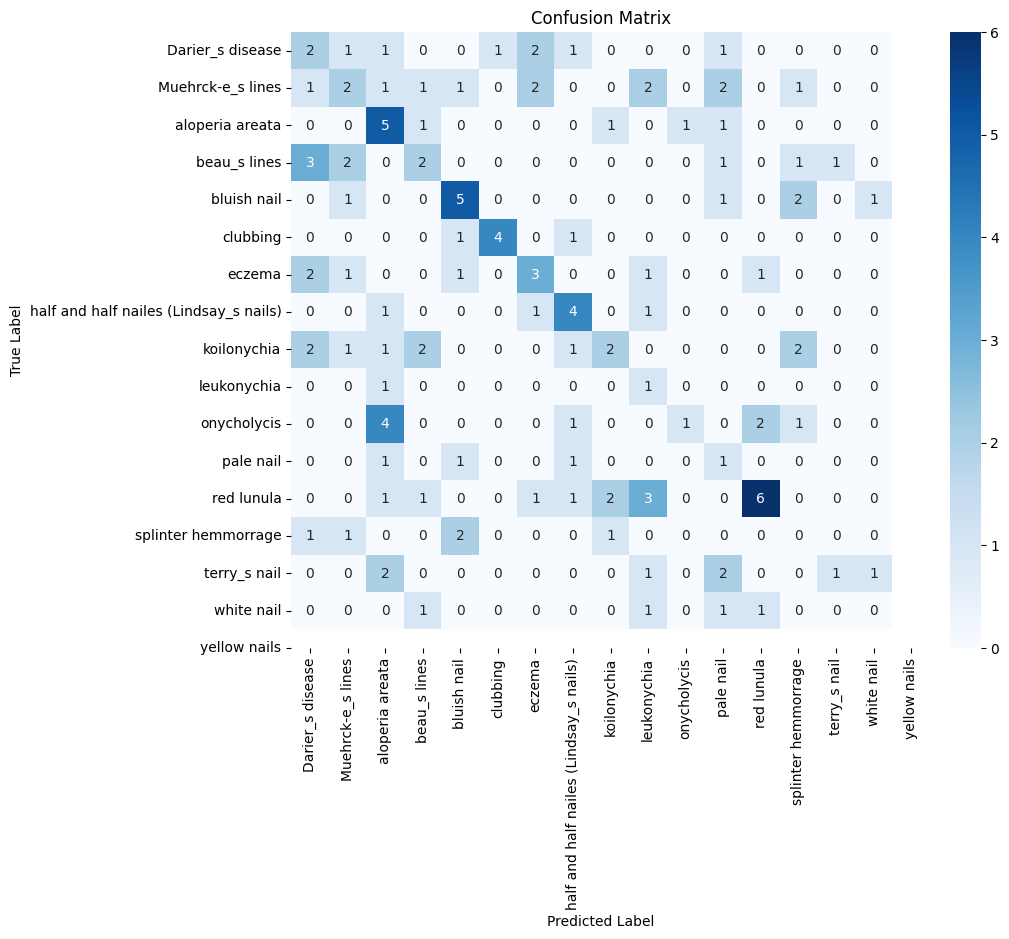

In [19]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [20]:
true_label_idx = class_names.index(predicted_label)
print(f"True label: {class_names[true_label_idx]}, Predicted label: {predicted_label}")
print(f"Confusion Matrix Value: {conf_matrix[true_label_idx, class_names.index(predicted_label)]}")

True label: aloperia areata, Predicted label: aloperia areata
Confusion Matrix Value: 5


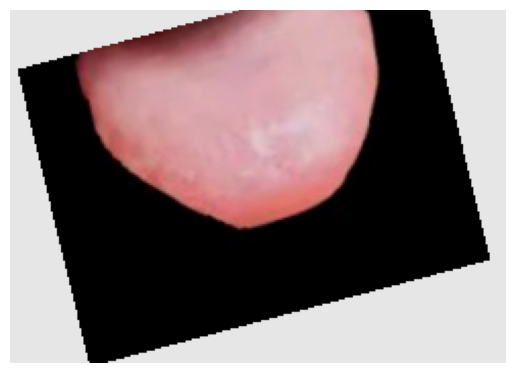

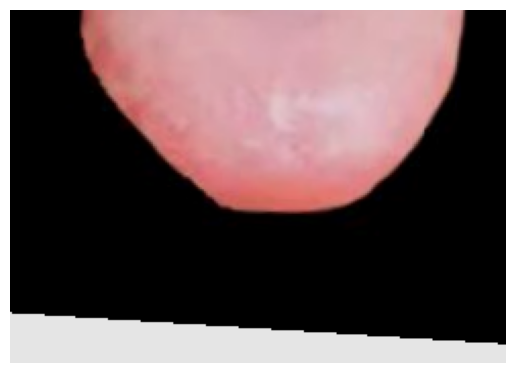

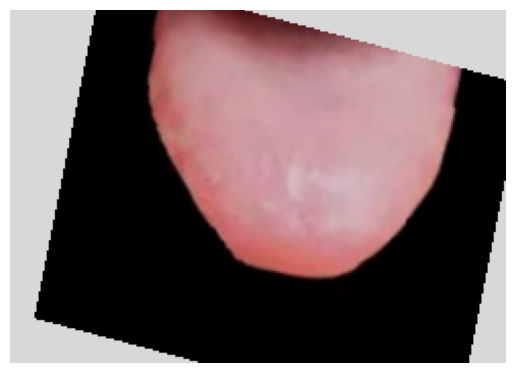

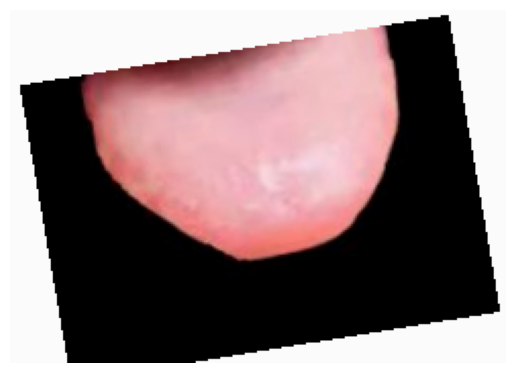

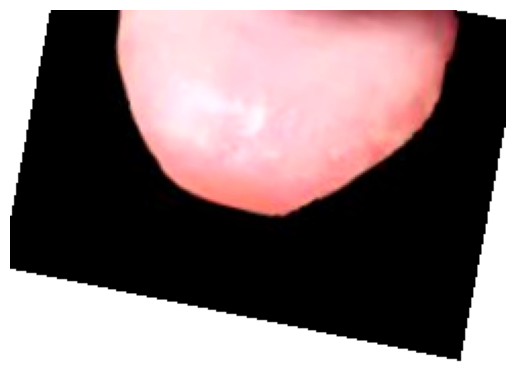

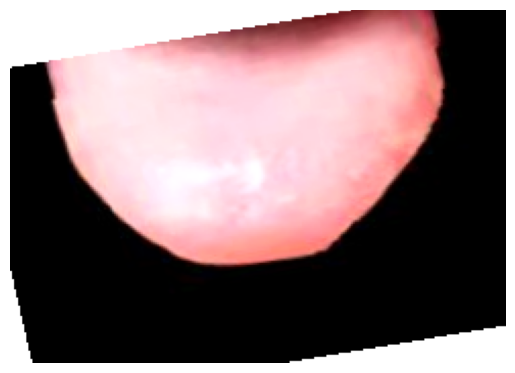

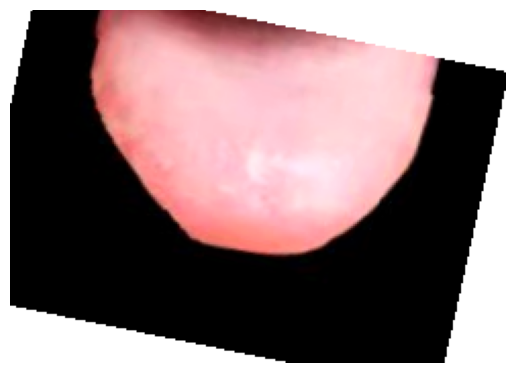

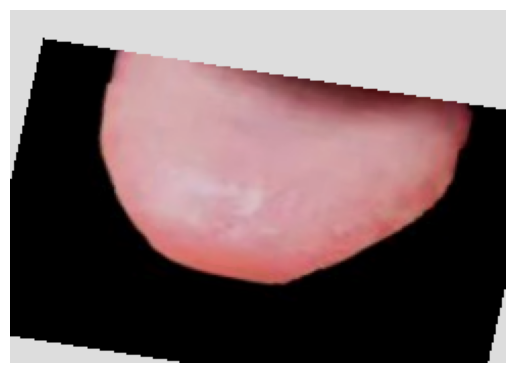

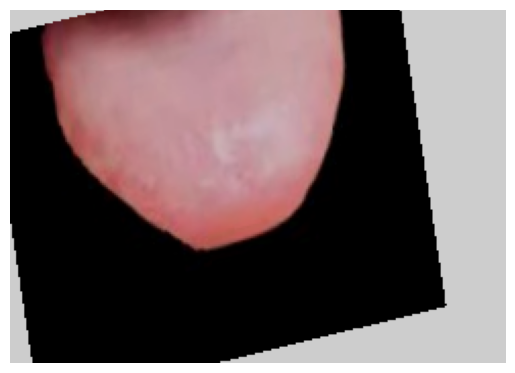

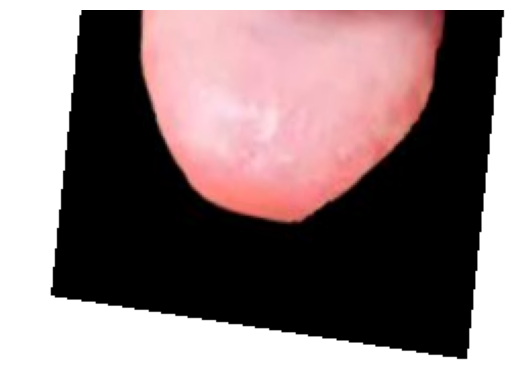

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Define the data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=15,            # Rotate the image up to 15 degrees
    width_shift_range=0.1,        # Shift the image horizontally by 10%
    height_shift_range=0.1,       # Shift the image vertically by 10%
    shear_range=0.01,             # Apply shear transformation
    zoom_range=[0.9, 1.25],       # Zoom in or out by 25%
    brightness_range=[0.8, 1.2],  # Adjust brightness
    horizontal_flip=True,         # Randomly flip the image horizontally
    fill_mode='constant',         # Fill empty pixels with a constant value
    cval=255                      # The constant value to fill the empty area, use RGB (255, 255, 255) for white
)

# Load the image
image_path = 'Tongue1.jpg'   # Replace with your image path
image = load_img(image_path)      # Load the image as PIL object

# Convert image to numpy array
x = img_to_array(image)
x = x.reshape((1,) + x.shape)     # Reshape to (1, height, width, channels)

# Directory to save augmented images
save_dir = 'augmented_images/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Generate and save augmented images
i = 0
for batch in datagen.flow(x, batch_size=1, save_to_dir=save_dir, save_prefix='tongue_healthy', save_format='png'):
    augmented_image = batch[0].astype('uint8')  # Convert back to uint8 for visualization

    # Optionally, visualize the augmented image
    plt.imshow(augmented_image)
    plt.axis('off')  # Hide axis
    plt.show()

    i += 1
    if i >= 10:  # Generate and save 10 augmented images
        break


In [2]:
# Import necessary libraries
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten

# Generator model
def create_generator():
    model = Sequential()
    model.add(Dense(256, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(28 * 28 * 1, activation='tanh'))
    model.add(Reshape((28, 28, 1)))
    return model


In [ ]:
import cv2
import numpy as np

# Load an image
image = cv2.imread('tongue_image.jpg')

# Convert the image to HSV (hue, saturation, value) format
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Adjust the hue to make the tongue more reddish (for heat-related issue simulation)
hue_shift = 10  # Shift hue by 10 degrees
hsv_image[:, :, 0] = (hsv_image[:, :, 0] + hue_shift) % 180

# Convert back to BGR format
modified_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)

# Save the modified image
cv2.imwrite('modified_tongue_image.jpg', modified_image)
